In [1]:
import os
import json
import torch
import torch.nn as nn
import torch.nn.functional as Fnn
from torchvision.transforms import functional as TF
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision
from torchvision.ops import roi_align, nms
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [2]:
# Root directory containing FasterRCNN and FracAtlas folders
ROOT = "/Users/rushendra/Desktop/UMN/Courses/Fall 2025/CV/Project/Code/Final Project/Final Project/Code"

# Images inside FracAtlas/images/{Fractured, Not_Fractured}
IMAGES_DIR = os.path.join(ROOT, "FracAtlas", "images")

# JSON files inside FasterRCNN/COCO JSON
JSON_DIR   = os.path.join(ROOT, "FasterRCNN", "COCO JSON")

TRAIN_JSON = os.path.join(JSON_DIR, "COCO_fracture_masks_train.json")
VAL_JSON   = os.path.join(JSON_DIR, "COCO_fracture_masks_val.json")
TEST_JSON  = os.path.join(JSON_DIR, "COCO_fracture_masks_test.json")

print("Images exist:", os.path.isdir(IMAGES_DIR))
print("Train JSON:", os.path.exists(TRAIN_JSON))
print("Val JSON:", os.path.exists(VAL_JSON))
print("Test JSON:", os.path.exists(TEST_JSON))

Images exist: True
Train JSON: True
Val JSON: True
Test JSON: True


In [3]:
class CustomCOCODataset(Dataset):
    def __init__(self, image_root, annotation_file):
        self.image_root = image_root

        with open(annotation_file, "r") as f:
            data = json.load(f)

        self.images = data["images"]
        self.annotations = data["annotations"]

        # Map id → annotations
        self.image_to_anns = {img["id"]: [] for img in self.images}
        for ann in self.annotations:
            self.image_to_anns[ann["image_id"]].append(ann)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_info = self.images[idx]
        fname = img_info["file_name"]

        path1 = os.path.join(self.image_root, "Fractured", fname)
        path2 = os.path.join(self.image_root, "Not_Fractured", fname)

        if os.path.exists(path1):
            img_path = path1
        elif os.path.exists(path2):
            img_path = path2
        else:
            raise FileNotFoundError(f"Image {fname} not found")

        img = Image.open(img_path).convert("RGB")

        # NEW: resize to fixed shape
        img = img.resize((800, 800))

        # load annotation
        anns = self.image_to_anns[img_info["id"]]
        boxes, labels = [], []
        for ann in anns:
            x, y, w, h = ann["bbox"]

            # scale bbox to resized image
            scale_x = 800 / img_info["width"]
            scale_y = 800 / img_info["height"]

            x1 = x * scale_x
            y1 = y * scale_y
            x2 = (x + w) * scale_x
            y2 = (y + h) * scale_y

            boxes.append([x1, y1, x2, y2])
            labels.append(ann["category_id"])

        target = {
            "boxes": torch.tensor(boxes, dtype=torch.float32),
            "labels": torch.tensor(labels, dtype=torch.int64)
        }

        return TF.to_tensor(img), target

In [4]:
train_dataset = CustomCOCODataset(IMAGES_DIR, TRAIN_JSON)
val_dataset   = CustomCOCODataset(IMAGES_DIR, VAL_JSON)
test_dataset  = CustomCOCODataset(IMAGES_DIR, TEST_JSON)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True,
                          collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False,
                        collate_fn=lambda x: tuple(zip(*x)))
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False,
                         collate_fn=lambda x: tuple(zip(*x)))

In [5]:
import torch
import torch.nn as nn
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.models.detection.faster_rcnn import FasterRCNN
from torchvision.ops import MultiScaleRoIAlign
from torchvision.models.detection.rpn import AnchorGenerator

# ---- Backbone wrapper using ResNet-50 ----
class ResNetBackbone(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        # base resnet
        weights = ResNet50_Weights.IMAGENET1K_V1 if pretrained else None
        resnet = resnet50(weights=weights)

        # take everything up to the last conv feature map (C5)
        self.body = nn.Sequential(*list(resnet.children())[:-2])
        self.out_channels = 2048  # C5 channels

    def forward(self, x):
        # FasterRCNN expects an OrderedDict of feature maps
        x = self.body(x)
        return {"0": x}


def build_faster_rcnn(num_classes: int, pretrained_backbone: bool = True):
    # 1. backbone
    backbone = ResNetBackbone(pretrained=pretrained_backbone)

    # 2. anchor generator (similar to torchvision default)
    anchor_generator = AnchorGenerator(
        sizes=((32, 64, 128, 256, 512),),      # one feature map -> one tuple
        aspect_ratios=((0.5, 1.0, 2.0),)
    )

    # 3. ROI pooling over the single feature map named "0"
    roi_pooler = MultiScaleRoIAlign(
        featmap_names=["0"],
        output_size=7,
        sampling_ratio=2,
    )

    # 4. Faster R-CNN model using our backbone + components
    model = FasterRCNN(
        backbone=backbone,
        num_classes=num_classes,                   # includes background class
        rpn_anchor_generator=anchor_generator,
        box_roi_pool=roi_pooler,
    )
    return model

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_classes = 2  # 1 fracture + background
model = build_faster_rcnn(num_classes=num_classes, pretrained_backbone=True)
model.to(device)

# standard Faster R-CNN optimizer settings
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005,
)

In [7]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = FasterRCNN(num_classes=2).to(device)
# model.eval()

In [8]:
def plot_image_with_boxes(img, original_boxes, predicted_boxes, predicted_scores):
    img = TF.to_pil_image(img)

    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(img)

    for box in original_boxes:
        x1, y1, x2, y2 = box.tolist()
        ax.add_patch(patches.Rectangle((x1, y1), x2-x1, y2-y1,
                                       edgecolor='blue', fill=False, linewidth=2))

    for box, score in zip(predicted_boxes, predicted_scores):
        x1, y1, x2, y2 = box.tolist()
        ax.add_patch(patches.Rectangle((x1, y1), x2-x1, y2-y1,
                                       edgecolor='red', fill=False, linewidth=2))
        ax.text(x1, y1-5, f"{score:.2f}", color='red')

    plt.axis('off')
    plt.show()

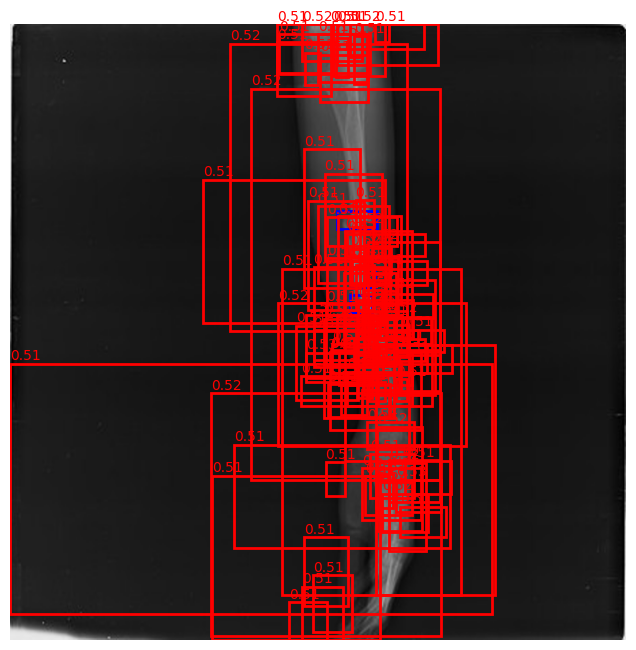

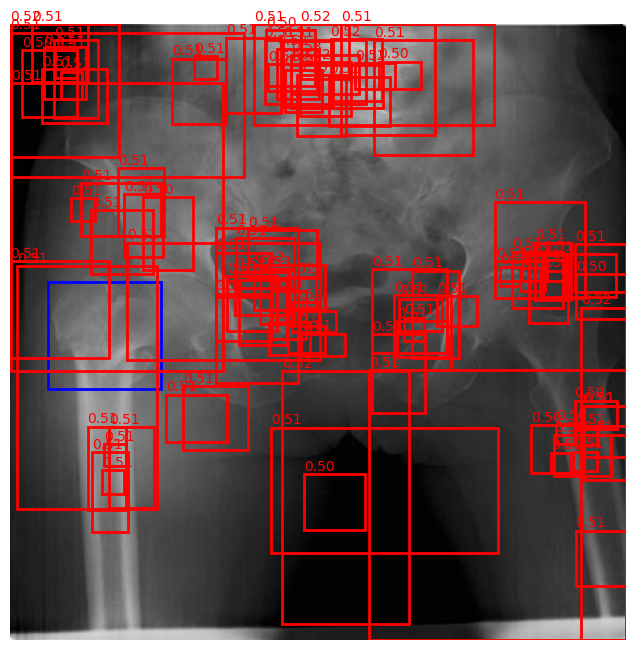

In [9]:
model.eval()
for imgs, targets in train_loader:
    imgs = [img.to(device) for img in imgs]
    outputs = model(imgs)

    for i, output in enumerate(outputs):
        img = imgs[i].cpu()
        gt_boxes = targets[i]["boxes"].cpu()
        pred_boxes = output["boxes"].cpu()
        pred_scores = output["scores"].detach().cpu().squeeze()

        plot_image_with_boxes(img, gt_boxes, pred_boxes, pred_scores)

    break

## Training

In [10]:
history = {
    "step_loss": [],
    "step_loss_classifier": [],
    "step_loss_box_reg": [],
    "step_loss_objectness": [],
    "step_loss_rpn_box_reg": [],
    
    "epoch_loss": [],
    "epoch_map": [],
    "epoch_iou": [],
}

In [11]:
import csv

LOG_STEP_FILE = "training_steps.csv"
LOG_EPOCH_FILE = "training_epoch_summary.csv"
HISTORY_JSON = "training_history.json"

# Initialize CSVs only once
if not os.path.exists(LOG_STEP_FILE):
    with open(LOG_STEP_FILE, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow([
            "step", 
            "loss", "cls", "box", "obj", "rpn"
        ])

if not os.path.exists(LOG_EPOCH_FILE):
    with open(LOG_EPOCH_FILE, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow([
            "epoch", "total_loss", "cls", "box", "obj", "rpn",
            "map50", "map5095", "mar"
        ])

def save_step_log(step, loss, cls, box, obj, rpn):
    with open(LOG_STEP_FILE, "a", newline="") as f:
        writer = csv.writer(f)
        writer.writerow([step, loss, cls, box, obj, rpn])

def save_epoch_log(epoch, loss, cls, box, obj, rpn, m50, m5095, mar):
    with open(LOG_EPOCH_FILE, "a", newline="") as f:
        writer = csv.writer(f)
        writer.writerow([epoch, loss, cls, box, obj, rpn, m50, m5095, mar])

def save_full_history(history):
    with open(HISTORY_JSON, "w") as f:
        json.dump(history, f, indent=4)

In [12]:
import torch
from torchvision.ops import box_iou

def compute_ap(recall, precision):
    recall = torch.cat([torch.tensor([0.0]), recall, torch.tensor([1.0])])
    precision = torch.cat([torch.tensor([1.0]), precision, torch.tensor([0.0])])

    # Make precision curve non-increasing
    for i in range(len(precision)-1, 0, -1):
        precision[i-1] = max(precision[i-1], precision[i])

    idx = (recall[1:] != recall[:-1]).nonzero(as_tuple=True)[0]
    ap = torch.sum((recall[idx+1] - recall[idx]) * precision[idx+1])
    return float(ap)


def evaluate_map(model, data_loader, device, iou_thresholds=None):
    model.eval()

    if iou_thresholds is None:
        iou_thresholds = torch.linspace(0.50, 0.95, 10)

    all_scores = []
    all_matches = []
    num_gts = 0

    with torch.no_grad():
        for imgs, targets in data_loader:
            imgs = [img.to(device) for img in imgs]
            outputs = model(imgs)

            for out, tgt in zip(outputs, targets):
                gt_boxes = tgt["boxes"].cpu()
                pred_boxes = out["boxes"].cpu()
                pred_scores = out["scores"].cpu()

                num_gts += len(gt_boxes)
                if pred_boxes.numel() == 0:
                    continue
                
                order = pred_scores.argsort(descending=True)
                pred_boxes = pred_boxes[order]
                pred_scores = pred_scores[order]

                if len(gt_boxes) == 0:
                    # no ground truths → all predictions are false positives
                    all_scores.append(pred_scores)
                    all_matches.append(torch.zeros(len(pred_scores)))
                    continue

                ious = box_iou(pred_boxes, gt_boxes)
                if ious.numel() > 0:
                    max_ious = ious.max(dim=1).values  # best match for each predicted box
                else:
                    max_ious = torch.zeros(len(pred_boxes))  # no GTs → they are false positives

                all_scores.append(pred_scores)
                all_matches.append(max_ious)

    if len(all_scores) == 0:
        return 0.0, 0.0, 0.0

    all_scores = torch.cat(all_scores)
    all_matches = torch.cat(all_matches)

    order = all_scores.argsort(descending=True)
    all_scores = all_scores[order]
    all_matches = all_matches[order]

    aps = []
    for thr in iou_thresholds:
        tp = (all_matches >= thr).float()
        fp = 1 - tp

        tp_cum = torch.cumsum(tp, 0)
        fp_cum = torch.cumsum(fp, 0)

        recall = tp_cum / num_gts
        precision = tp_cum / (tp_cum + fp_cum + 1e-8)

        aps.append(compute_ap(recall, precision))

    map50 = aps[0]
    map5095 = sum(aps) / len(aps)
    mar = float(tp_cum[-1] / num_gts)

    return map50, map5095, mar

In [ ]:
import torch
from tqdm import tqdm

num_epochs = 10
checkpoint_path = "fasterrcnn_checkpoint.pth"

global_step = 0

for epoch in range(num_epochs):
    model.train()

    epoch_loss = []
    epoch_loss_classifier = []
    epoch_loss_box_reg = []
    epoch_loss_objectness = []
    epoch_loss_rpn_box_reg = []

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

    for imgs, targets in pbar:
        global_step += 1
        
        imgs = [img.to(device) for img in imgs]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(imgs, targets)
        loss = sum(loss_dict.values())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Extract floats
        lc  = loss_dict["loss_classifier"].item()
        lbr = loss_dict["loss_box_reg"].item()
        lo  = loss_dict["loss_objectness"].item()
        lrpn = loss_dict["loss_rpn_box_reg"].item()
        loss_float = lc + lbr + lo + lrpn

        # Save step logs to CSV
        save_step_log(global_step, loss_float, lc, lbr, lo, lrpn)

        # Track per-step in memory also
        history["step_loss"].append(loss_float)
        history["step_loss_classifier"].append(lc)
        history["step_loss_box_reg"].append(lbr)
        history["step_loss_objectness"].append(lo)
        history["step_loss_rpn_box_reg"].append(lrpn)

        # Accumulate epoch stats
        epoch_loss.append(loss_float)
        epoch_loss_classifier.append(lc)
        epoch_loss_box_reg.append(lbr)
        epoch_loss_objectness.append(lo)
        epoch_loss_rpn_box_reg.append(lrpn)

        pbar.set_postfix({
            "loss": f"{loss_float:.4f}",
            "cls": f"{lc:.3f}",
            "box": f"{lbr:.3f}",
            "obj": f"{lo:.3f}",
            "rpn": f"{lrpn:.3f}",
        })

    # Compute epoch averages
    avg_loss = sum(epoch_loss) / len(epoch_loss)
    avg_lc   = sum(epoch_loss_classifier) / len(epoch_loss_classifier)
    avg_lbr  = sum(epoch_loss_box_reg) / len(epoch_loss_box_reg)
    avg_lo   = sum(epoch_loss_objectness) / len(epoch_loss_objectness)
    avg_lrpn = sum(epoch_loss_rpn_box_reg) / len(epoch_loss_rpn_box_reg)

    # Evaluate model
    map50, map5095, mar = evaluate_map(model, val_loader, device)

    # Save epoch summary to CSV
    save_epoch_log(epoch+1, avg_loss, avg_lc, avg_lbr, avg_lo, avg_lrpn, map50, map5095, mar)

    # Save in-memory history
    history["train_loss"].append(avg_loss)
    history["loss_classifier"].append(avg_lc)
    history["loss_box_reg"].append(avg_lbr)
    history["loss_objectness"].append(avg_lo)
    history["loss_rpn_box_reg"].append(avg_lrpn)
    history["map50"].append(map50)
    history["map5095"].append(map5095)
    history["mar"].append(mar)

    # Finally save JSON history every epoch
    save_full_history(history)

    # Save checkpoint
    torch.save(model.state_dict(), checkpoint_path)
    print("Checkpoint saved.\n")

Epoch 1/10:   5%|▍         | 14/287 [00:58<18:18,  4.02s/it, loss=0.1545, cls=0.098, box=0.012, obj=0.042, rpn=0.003]